In [1]:
import pandas as pd
import numpy as np
import json
import holidays
import joblib
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [3]:


# ============================================
# 1. Load and Preprocess Data
# ============================================

# Load raw data
df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')

# Load saved encodings from v7 model
with open('Models/baseline_model_v7/opponent_encoding_v7.json', 'r') as f:
    opponent_encoding = json.load(f)

with open('Models/baseline_model_v7/sunday_multipliers_v7.json', 'r') as f:
    sunday_multipliers = json.load(f)

with open('Models/baseline_model_v7/feature_cols_v7.json', 'r') as f:
    feature_cols = json.load(f)

# Parse datetime
df['datetime'] = pd.to_datetime(df['date'])

# Extract time features
df['month'] = df['datetime'].dt.month
df['weekday_num'] = df['datetime'].dt.weekday

# Parse hour - handle malformed data
def parse_hour(x):
    if pd.isna(x):
        return 19.5
    x_str = str(x)
    if '.' in x_str:
        try:
            parts = x_str.split('.')
            hour = float(parts[0])
            mins = float(parts[1][:2])  # Take only first 2 chars for minutes
            return hour + mins/60
        except (ValueError, IndexError):
            return 19.5
    return 19.5

df['hour'] = df['time'].apply(parse_hour)

# Cyclical encoding
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday_num'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday_num'] / 7)
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)

# Sunday score
def calc_sunday_score(row):
    if row['weekday_num'] == 6:
        return 2.0 if 14 <= row['hour'] <= 17 else 1.0
    return 0.0

df['sunday_score'] = df.apply(calc_sunday_score, axis=1)

# Holiday features
german_holidays = holidays.Germany(state='NI', years=[2022, 2023, 2024, 2025])

def calc_holiday_features(row):
    dt = row['datetime']
    date_obj = dt.date()
    is_dec_holiday = 1 if (dt.month == 12 and dt.day >= 20) else 0
    score = 0
    if date_obj in german_holidays:
        score += 2
    if (dt.month == 12 and dt.day >= 20) or (dt.month == 1 and dt.day <= 6):
        score += 2
    if dt.month == 10 and 4 <= dt.day <= 19:
        score += 1
    return pd.Series([is_dec_holiday, score])

df[['is_dec_holiday', 'holiday_score']] = df.apply(calc_holiday_features, axis=1)

# Game progress per season
def calc_game_progress(group):
    min_st = group['spieltag'].min()
    max_st = group['spieltag'].max()
    if max_st == min_st:
        return pd.Series([0.0] * len(group), index=group.index)
    return (group['spieltag'] - min_st) / (max_st - min_st)

# df['game_progress'] = df.groupby('season').apply(calc_game_progress).reset_index(level=0, drop=True)

# DON'T recalculate - use the saved encodings which were trained on 22-23, 23-24 only
# The saved opponent_encoding_v7.json and sunday_multipliers_v7.json are correct

# Just make sure game_progress is per-season (this is correct)
df['game_progress'] = df.groupby('season')['spieltag'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Opponent features
global_median = 1547
df['opponent_attendance'] = df['away_team'].map(opponent_encoding).fillna(global_median)
df['distance_log'] = np.log(df['distance'])

top_opponents = ['Eisbären Berlin', 'Düsseldorfer EG', 'Kölner Haie', 'Pinguins Bremerhaven']
df['is_top_opponent'] = df['away_team'].isin(top_opponents).astype(int)

# Interaction features
df['sunday_boost'] = df['sunday_score'] * (df['opponent_attendance'] / global_median)
df['sunday_mult'] = df['away_team'].map(sunday_multipliers).fillna(1.0)
df['sunday_opp_adj'] = df['sunday_score'] * df['sunday_mult']
df['sunday_top'] = df['sunday_score'] * df['is_top_opponent']

df = df.fillna(0)



In [4]:
# ============================================
# 2. Filter to 24-25 Season and Predict
# ============================================

df_test = df[df['season'] == '24-25'].copy().sort_values('datetime').reset_index(drop=True)

# Load models
scaler = joblib.load('Models/baseline_model_v7/scaler_v7.joblib')
ridge = joblib.load('Models/baseline_model_v7/ridge_v7.joblib')
catboost = CatBoostRegressor()
catboost.load_model('Models/baseline_model_v7/catboost_v7.cbm')

# Prepare features and predict
X_test = df_test[feature_cols]
X_scaled = scaler.transform(X_test)
pred_ridge = ridge.predict(X_scaled)
pred_catboost = catboost.predict(X_test)
predictions = (pred_ridge + pred_catboost) / 2

# Create results dataframe
results = pd.DataFrame({
    'date': df_test['datetime'].dt.strftime('%Y-%m-%d'),
    'opponent': df_test['away_team'],
    'actual': df_test['ticket_count'],
    'predicted': np.round(predictions, 0),
    'error': df_test['ticket_count'] - predictions
})

print("24-25 Season: Actual vs Predicted")
print("=" * 70)
print(results.to_string(index=False))
print("\n" + "=" * 70)
print(f"MAE: {np.abs(results['error']).mean():.2f}")
print(f"RMSE: {np.sqrt((results['error']**2).mean()):.2f}")




24-25 Season: Actual vs Predicted
      date                opponent  actual  predicted       error
2024-09-22         Düsseldorfer EG  1944.0     2222.0 -278.450523
2024-09-27       Iserlohn Roosters  1439.0     1383.0   56.455057
2024-10-04 Schwenninger Wild Wings  1466.0     1031.0  435.484240
2024-10-13          Adler Mannheim  1683.0     1601.0   82.177248
2024-10-20         Eisbären Berlin  2712.0     2257.0  454.936433
2024-10-31          Adler Mannheim  1926.0     1255.0  670.732144
2024-11-17 Schwenninger Wild Wings  2151.0     1313.0  838.383957
2024-11-21      Augsburger Panther   901.0      978.0  -77.245029
2024-11-27         Düsseldorfer EG  1305.0     1432.0 -126.801978
2024-11-29             Kölner Haie  1618.0     1495.0  122.773076
2024-12-06    EHC Red Bull München  1339.0     1273.0   65.872482
2024-12-13     Nürnberg Ice Tigers  1252.0     1213.0   39.312806
2024-12-18          ERC Ingolstadt  1006.0     1043.0  -36.594070
2024-12-22         Löwen Frankfurt  2265.0

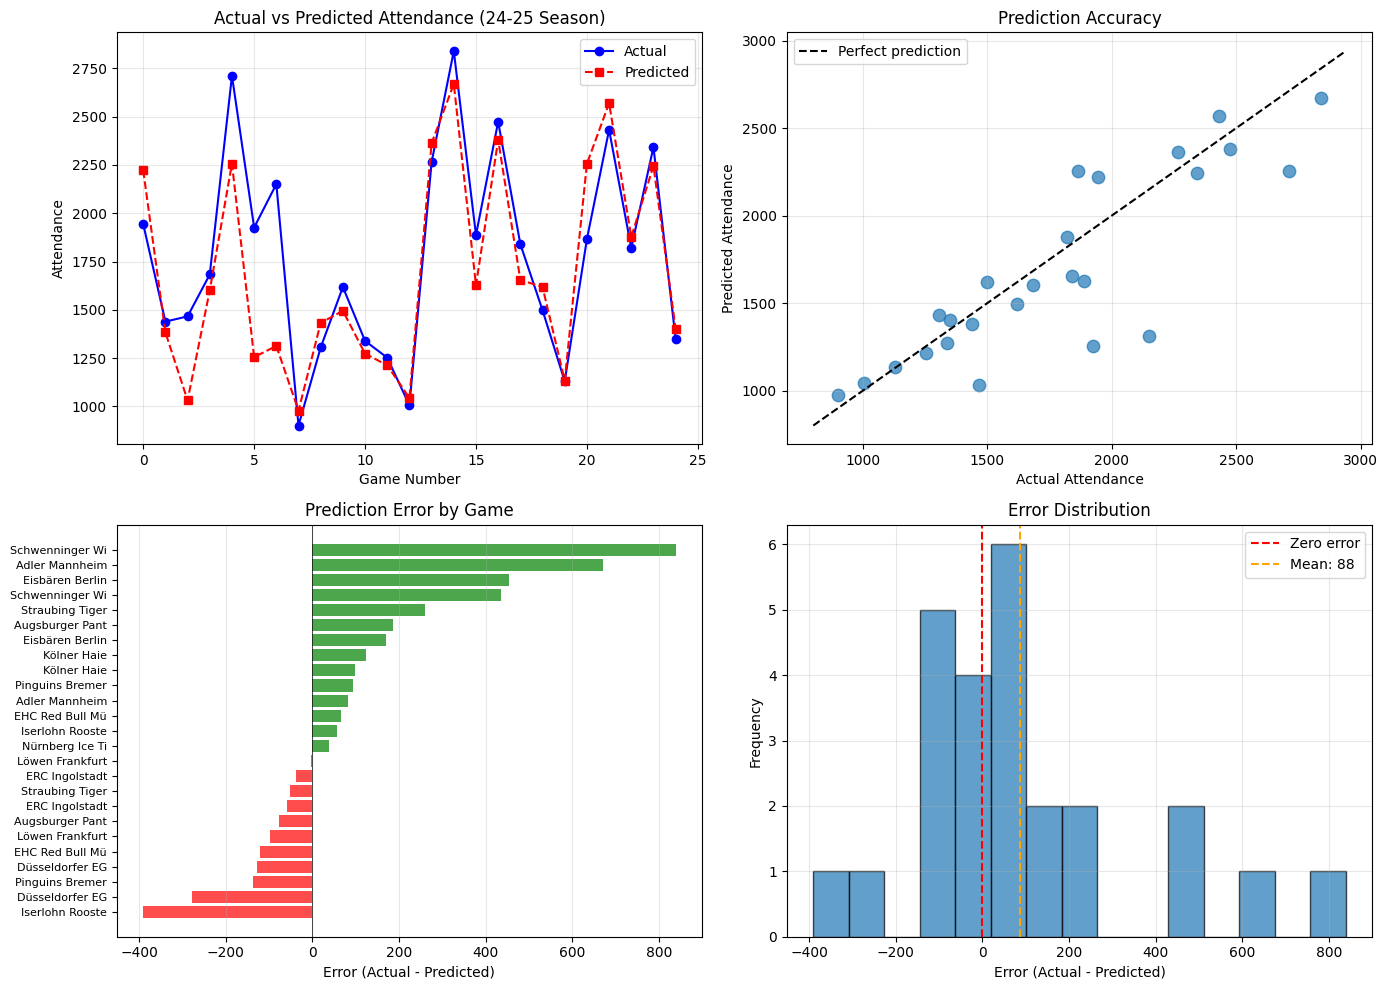

In [5]:
# ============================================
# 3. Visualizations
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Line chart - Actual vs Predicted over time
ax1 = axes[0, 0]
x = range(len(results))
ax1.plot(x, results['actual'], 'b-o', label='Actual', markersize=6)
ax1.plot(x, results['predicted'], 'r--s', label='Predicted', markersize=6)
ax1.set_xlabel('Game Number')
ax1.set_ylabel('Attendance')
ax1.set_title('Actual vs Predicted Attendance (24-25 Season)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter plot - Actual vs Predicted
ax2 = axes[0, 1]
ax2.scatter(results['actual'], results['predicted'], alpha=0.7, s=80)
min_val = min(results['actual'].min(), results['predicted'].min()) - 100
max_val = max(results['actual'].max(), results['predicted'].max()) + 100
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')
ax2.set_xlabel('Actual Attendance')
ax2.set_ylabel('Predicted Attendance')
ax2.set_title('Prediction Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Error bar chart by opponent
ax3 = axes[1, 0]
results_sorted = results.sort_values('error')
colors = ['green' if e > 0 else 'red' for e in results_sorted['error']]
bars = ax3.barh(range(len(results_sorted)), results_sorted['error'], color=colors, alpha=0.7)
ax3.set_yticks(range(len(results_sorted)))
ax3.set_yticklabels([f"{r['opponent'][:15]}" for _, r in results_sorted.iterrows()], fontsize=8)
ax3.set_xlabel('Error (Actual - Predicted)')
ax3.set_title('Prediction Error by Game')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Error distribution histogram
ax4 = axes[1, 1]
ax4.hist(results['error'], bins=15, edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='red', linestyle='--', label='Zero error')
ax4.axvline(x=results['error'].mean(), color='orange', linestyle='--', label=f'Mean: {results["error"].mean():.0f}')
ax4.set_xlabel('Error (Actual - Predicted)')
ax4.set_ylabel('Frequency')
ax4.set_title('Error Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# Summary Statistics
print("\nTop 5 Best Predictions:")
best = results.loc[results['error'].abs().nsmallest(5).index]
for _, row in best.iterrows():
    print(f"  {row['date']} vs {row['opponent']}: Error = {row['error']:.0f}")

print("\nTop 5 Worst Predictions:")
worst = results.loc[results['error'].abs().nlargest(5).index]
for _, row in worst.iterrows():
    print(f"  {row['date']} vs {row['opponent']}: Error = {row['error']:.0f}")


Top 5 Best Predictions:
  2025-01-28 vs Löwen Frankfurt: Error = -4
  2024-12-18 vs ERC Ingolstadt: Error = -37
  2024-12-13 vs Nürnberg Ice Tigers: Error = 39
  2025-03-04 vs Straubing Tigers: Error = -52
  2024-09-27 vs Iserlohn Roosters: Error = 56

Top 5 Worst Predictions:
  2024-11-17 vs Schwenninger Wild Wings: Error = 838
  2024-10-31 vs Adler Mannheim: Error = 671
  2024-10-20 vs Eisbären Berlin: Error = 455
  2024-10-04 vs Schwenninger Wild Wings: Error = 435
  2025-02-02 vs Iserlohn Roosters: Error = -390
